### Laboratorio 5

Stefano Aragoni, Carol Arevalo

2/2 [==============================] - 0s 7ms/step
0/1000 [D loss: 0.8066156506538391 | D accuracy: 42.1875] [G loss: 0.9687063097953796]
2/2 [==============================] - 0s 6ms/step
1/1000 [D loss: 0.3429912254214287 | D accuracy: 98.4375] [G loss: 0.9836673140525818]
2/2 [==============================] - 0s 7ms/step
2/1000 [D loss: 0.2817421033978462 | D accuracy: 100.0] [G loss: 0.987149715423584]
2/2 [==============================] - 0s 7ms/step
3/1000 [D loss: 0.24271209444850683 | D accuracy: 100.0] [G loss: 1.0100926160812378]
2/2 [==============================] - 0s 6ms/step
4/1000 [D loss: 0.21137956529855728 | D accuracy: 100.0] [G loss: 1.029746651649475]
2/2 [==============================] - 0s 6ms/step
5/1000 [D loss: 0.19237072486430407 | D accuracy: 100.0] [G loss: 1.0653932094573975]
2/2 [==============================] - 0s 6ms/step
6/1000 [D loss: 0.16901571117341518 | D accuracy: 100.0] [G loss: 1.0751490592956543]
2/2 [==============================] - 0s 

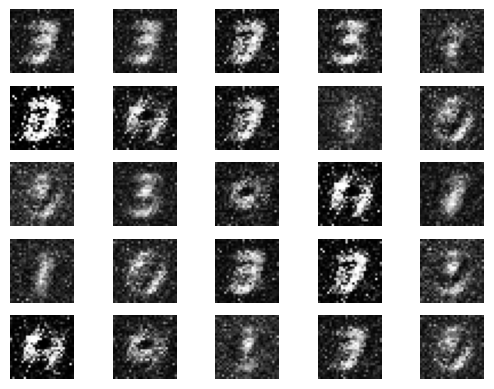

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Cargar el dataset MNIST
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalizar a [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Parámetros
img_shape = X_train[0].shape
latent_dim = 100

# Generador
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model

# Discriminador
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compilar Discriminador
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Generador
generator = build_generator()
z = Input(shape=(latent_dim,))
img = generator(z)

# El discriminador no debe ser entrenado durante el entrenamiento del generador
discriminator.trainable = False

# Discriminador para evaluar el generador
validity = discriminator(img)

# El modelo combinado
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Entrenamiento
epochs = 10
batch_size = 128
half_batch = batch_size // 2

for epoch in range(epochs):
    # Entrenar el discriminador
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_imgs = generator.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch(noise, valid_labels)

    # Imprimir el progreso
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, latent_dim))
gen_imgs = generator.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(gen_imgs[i * 5 + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
plt.show()
